<a href="https://colab.research.google.com/github/jomarisidro/conBERT/blob/main/conBERT_FINAL_PROJECT_CLEAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ================================================
# 🪄 STEP 0: UPLOADING OF DATASET
# ================================================
from google.colab import files
print("📤 Please upload your essay_dataset.csv file...")
uploaded = files.upload()

import io
import pandas as pd
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print(f"✅ File '{filename}' uploaded successfully. Shape: {df.shape}")


📤 Please upload your essay_dataset.csv file...


Saving essay_dataset.csv to essay_dataset (1).csv
✅ File 'essay_dataset (1).csv' uploaded successfully. Shape: (1000, 11)


In [2]:


# ================================================
# 🪄 STEP 1: INSTALL REQUIRED LIBRARIES
# ================================================
!pip install -q transformers==4.44.2 datasets==2.19.1 evaluate==0.4.1 accelerate==0.33.0
!pip install -q sentence-transformers==3.0.1 scikit-learn==1.5.0 tqdm==4.66.4 matplotlib

!pip install --quiet language_tool_python
import language_tool_python

# Initialize once
tool = language_tool_python.LanguageTool('en-US')



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 3.5 MB/s eta 0:00:00


In [3]:


# ================================================
# 🧩 STEP 2: IMPORT LIBRARIES
# ================================================
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
import re
import os

from transformers import Trainer, TrainingArguments, AutoTokenizer
from datasets import Dataset
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt



/usr/local/lib/python3.12/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [4]:


# ================================================
# 🧩 STEP 2b: DEFINE CUSTOM MULTI-OUTPUT REGRESSION MODEL
# ================================================
from transformers import BertModel
import torch.nn as nn
import torch

class BertMultiRegressor(nn.Module):
    def __init__(self, model_ckpt, n_outputs=3):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_ckpt)
        self.regressor = nn.Linear(self.bert.config.hidden_size, n_outputs)  # 4 outputs: final, grammar, coherence, relevance

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        pooled = outputs.pooler_output
        logits = self.regressor(pooled)

        loss = None
        if labels is not None:
            labels = labels.float()
            loss_fn = nn.MSELoss()
            loss = loss_fn(logits, labels)  # shape: [batch_size, 4]

        return {"loss": loss, "logits": logits}



In [5]:


# ================================================
# 📂 STEP 3: LOAD THE DATASET
# ================================================
print("📂 Loaded dataset shape:", df.shape)
df.head()

# ================================================
# 🧹 STEP 4: REMOVE MISSING VALUES
# ================================================
important_cols = ["essay_text", "grammar_score", "coherence_score", "content_relevance_score"]
initial_count = df.shape[0]
df = df.dropna(subset=important_cols)
dropped = initial_count - df.shape[0]
print(f"🔻 Dropped {dropped} rows after STEP 4 (missing values)")
initial_count = df.shape[0]


📂 Loaded dataset shape: (1000, 11)
🔻 Dropped 0 rows after STEP 4 (missing values)


In [6]:


# ================================================
# 🗑️ STEP 5a: REMOVE DUPLICATES BASED ON TOKENS + FINAL SCORE
# ================================================
def normalize_tokens(x):
    if isinstance(x, list):
        return " ".join(x)
    elif isinstance(x, str):
        return " ".join(re.findall(r"\b\w[\w\-]*\b", x))
    else:
        return str(x)

df["token_signature"] = df["word_tokens"].apply(normalize_tokens)

# Drop duplicates based on both normalized tokens and final_score
df = df.drop_duplicates(subset=["token_signature", "final_score"]).reset_index(drop=True)

dropped = initial_count - df.shape[0]
print(f"🔻 Dropped {dropped} rows after STEP 5a (duplicates based on word_tokens + final_score)")
initial_count = df.shape[0]


🔻 Dropped 6 rows after STEP 5a (duplicates based on word_tokens + final_score)


In [7]:


# ================================================
# ✂️ STEP 5b: REMOVE SHORT ESSAYS
# ================================================
df = df[df["essay_text"].str.strip().str.len() > 10].reset_index(drop=True)
dropped = initial_count - df.shape[0]
print(f"🔻 Dropped {dropped} rows after STEP 5b (short essays)")
initial_count = df.shape[0]

🔻 Dropped 0 rows after STEP 5b (short essays)


In [8]:


# ================================================
# 🧾 STEP 6: COMPUTE FINAL SCORE (IF MISSING)
# ================================================
if "final_score" not in df.columns:
    df["final_score"] = df[["grammar_score", "coherence_score", "content_relevance_score"]].mean(axis=1)
df = df.dropna(subset=["final_score"]).reset_index(drop=True)
dropped = initial_count - df.shape[0]
print(f"🔻 Dropped {dropped} rows after STEP 6 (missing final_score)")
initial_count = df.shape[0]

🔻 Dropped 0 rows after STEP 6 (missing final_score)


In [9]:



# ================================================
# 🧠 STEP 7: ASSIGN TOPIC BASED ON KEYWORDS
# ================================================
df["_essay_lower"] = df["essay_text"].str.lower()

topic_keywords = {
    "education": [
        "education", "students", "school", "learning", "teacher", "curriculum", "university",
        "classroom", "academic", "homework", "exam", "literacy", "pedagogy", "scholarship",
        "principal", "tuition", "degree", "college", "study", "textbook"
    ],
    "environment": [
        "environment", "climate", "pollution", "sustainability", "conservation", "ecosystem", "recycle",
        "biodiversity", "carbon", "greenhouse", "global warming", "deforestation", "renewable",
        "solar", "wind", "compost", "emissions", "habitat", "ecology"
    ],
    "ai": [
        "ai", "artificial intelligence", "machine learning", "deep learning", "neural network", "automation", "algorithm",
        "chatbot", "data science", "natural language processing", "computer vision", "robotics",
        "intelligent systems", "predictive", "modeling", "training data", "generative", "reinforcement learning"
    ],
    "health": [
        "health", "medicine", "disease", "healthcare", "nutrition", "wellness", "mental health",
        "hospital", "doctor", "patient", "treatment", "vaccine", "fitness", "exercise",
        "public health", "epidemic", "therapy", "diagnosis", "symptoms", "medical"
    ]
}


def assign_topic(text):
    counts = {t:0 for t in topic_keywords}
    for t, kws in topic_keywords.items():
        for kw in kws:
            counts[t] += len(re.findall(r"\b" + re.escape(kw) + r"\b", text))
    best = max(counts.items(), key=lambda x: x[1])
    return best[0] if best[1] > 0 else "other"

tqdm.pandas()
df["topic"] = df["_essay_lower"].progress_apply(assign_topic)


100%|██████████| 994/994 [00:00<00:00, 1912.75it/s]


In [10]:


# ================================================
# 🧾 STEP 8: CREATE CONTEXT-RICH INPUT TEXT
# ================================================
topic_prompts = {
    "education": "Discuss the importance of education in modern society.",
    "environment": "Explain how humans can protect and improve the environment.",
    "ai": "Discuss the impact of artificial intelligence on society and daily life.",
    "health": "Explain why health and healthcare are important for society.",
    "other": "Discuss the given topic."
}
df["input_text"] = df.apply(
    lambda r: (
        f"Topic: {r['topic']}. Prompt: {topic_prompts.get(r['topic'], topic_prompts['other'])}\n\n"
        f"Essay: {r['essay_text']}"
    ),
    axis=1
)


In [11]:


# ================================================
# 📈 STEP 9: FINAL SCORE (RAW, NOT SCALED)
# ================================================

score_cols = ["grammar_score", "coherence_score", "content_relevance_score"]
df["labels"] = df[score_cols].apply(lambda x: [float(i) for i in x], axis=1)





In [12]:


# ================================================
# 🧮 STEP 10: COMPUTE SEMANTIC SIMILARITY
# ================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("\n💻 Using device for embeddings:", device)
embed_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

prompt_embs = {t: embed_model.encode(p, convert_to_tensor=True) for t, p in topic_prompts.items()}

batch_size = 64
semantic_scores = []
texts = df["essay_text"].tolist()
topics = df["topic"].tolist()

for i in tqdm(range(0, len(df), batch_size), desc="Embedding batches"):
    batch_texts = texts[i:i+batch_size]
    batch_topics = topics[i:i+batch_size]
    batch_embs = embed_model.encode(batch_texts, convert_to_tensor=True)
    for emb, t in zip(batch_embs, batch_topics):
        prompt_e = prompt_embs.get(t, prompt_embs["other"])
        sim = util.cos_sim(emb, prompt_e).item()
        sim01 = (sim + 1.0) / 2.0
        semantic_scores.append(sim01)

df["semantic_score"] = semantic_scores



💻 Using device for embeddings: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding batches: 100%|██████████| 16/16 [00:01<00:00, 12.36it/s]


In [13]:


# ================================================
# 🧾 STEP 10b: INJECT SEMANTIC + SCORE FEATURES
# ================================================
df["input_text"] = df.apply(
    lambda r: (
        f"{r['input_text']}\n\n"
        f"Semantic Score: {r['semantic_score']:.2f}. "
        f"Grammar: {r['grammar_score']:.2f}, Coherence: {r['coherence_score']:.2f}, Relevance: {r['content_relevance_score']:.2f}"
    ),
    axis=1
)


In [14]:


# ================================================
# 💾 STEP 11: SAVE THE CLEANED DATASET
# ================================================
df = df.drop(columns=["_essay_lower"])
df["essay_preview"] = df["essay_text"].str.slice(0,160)
df.to_csv("essay_dataset_preprocessed.csv", index=False)
print(f"\n✅ STEP 11 DONE: Preprocessing complete.")
print("💾 Saved as essay_dataset_preprocessed.csv")
print("📏 Final dataset shape:", df.shape)



✅ STEP 11 DONE: Preprocessing complete.
💾 Saved as essay_dataset_preprocessed.csv
📏 Final dataset shape: (994, 17)


In [15]:


# ============================================================
# 🤖 STEP 12: TOKENIZATION AND MODEL PREPARATION
# ============================================================
print("\n🔤 Starting tokenization using bert-base-uncased tokenizer...")

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Store original row index for later reconstruction
df["row_id"] = df.index

dataset = Dataset.from_pandas(df[["row_id", "input_text", "labels"]])
dataset = dataset.train_test_split(test_size=0.2, seed=42)


# 🧠 Tokenization with truncation + padding
def tokenize_function(examples):
    return tokenizer(
        examples["input_text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

tokenized_train = dataset["train"].map(tokenize_function, batched=True)
tokenized_test = dataset["test"].map(tokenize_function, batched=True)

print("✅ Tokenization complete. Example keys:", tokenized_train.features.keys())

# Load multi-output model
model = BertMultiRegressor(model_ckpt, n_outputs=3)





🔤 Starting tokenization using bert-base-uncased tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/795 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

✅ Tokenization complete. Example keys: dict_keys(['row_id', 'input_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'])


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [16]:
# ============================================================
# 13. DEFINE METRICS
# ============================================================
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.squeeze(predictions)

    # If labels are 2D, compute per-output metric
    if preds.ndim > 1:
        metrics = {}
        mse_list = []
        for i, name in enumerate(["grammar", "coherence", "relevance"]):
            metrics[f"eval_{name}_pearsonr"] = float(pearsonr(preds[:, i], labels[:, i])[0])
            mse_val = float(np.mean((preds[:, i] - labels[:, i])**2))
            metrics[f"eval_{name}_mse"] = mse_val
            mse_list.append(mse_val)
            metrics[f"eval_{name}_mae"] = float(mean_absolute_error(labels[:, i], preds[:, i]))
            metrics[f"eval_{name}_r2"] = float(r2_score(labels[:, i], preds[:, i]))

        # Overall average MSE across all outputs
        metrics["eval_mse"] = float(np.mean(mse_list))
        return metrics
    else:
        corr, _ = pearsonr(preds, labels)
        mse = np.mean((preds - labels)**2)
        mae = mean_absolute_error(labels, preds)
        r2 = r2_score(labels, preds)
        return {
            "eval_pearsonr": float(corr),
            "eval_mse": float(mse),
            "eval_mae": float(mae),
            "eval_r2": float(r2)
        }


In [17]:
# ============================================================
# 14. TRAINING SETUP
# ============================================================

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=16,             # From trial result
    per_device_eval_batch_size=16,
    warmup_steps=100,                           # Updated from best trial
    learning_rate=3e-05,                        # Added from best trial
    weight_decay=0.01,                          # From best trial
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="mse",
    greater_is_better=False,
    fp16=torch.cuda.is_available(),
    report_to=[]
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("✅ Trainer initialized. Starting training...")
trainer.train()


/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


✅ Trainer initialized. Starting training...


Epoch,Training Loss,Validation Loss,Grammar Pearsonr,Grammar Mse,Grammar Mae,Grammar R2,Coherence Pearsonr,Coherence Mse,Coherence Mae,Coherence R2,Relevance Pearsonr,Relevance Mse,Relevance Mae,Relevance R2,Mse
1,No log,33.502552,0.004881,29.057833,5.174523,-11.734452,0.077583,32.010487,5.487062,-15.760393,-0.114331,39.439316,6.128631,-20.144405,33.502545
2,35.480300,6.546299,0.041100,5.996419,1.958271,-1.627901,0.094314,5.303689,1.901460,-1.776963,-0.198332,8.338785,2.543103,-3.470632,6.546298
3,35.480300,2.119206,-0.081068,2.370199,1.344517,-0.038728,0.018496,1.912537,1.172648,-0.001387,-0.149712,2.074883,1.236747,-0.112396,2.119206
4,2.755000,2.107598,-0.078518,2.402460,1.354626,-0.052866,0.148440,2.032592,1.208223,-0.064246,-0.134179,1.887740,1.192524,-0.012065,2.107598
5,2.755000,1.828273,0.643030,1.546844,1.013900,0.322103,0.549186,1.821212,1.095349,0.046430,0.421763,2.116760,1.176479,-0.134848,1.828272
6,1.723900,1.464733,0.624049,1.394518,0.965772,0.388859,0.596780,1.370352,0.967826,0.282496,0.472365,1.629329,1.049903,0.126476,1.464733
7,1.723900,1.188122,0.703259,1.157252,0.864263,0.492840,0.582910,1.378379,0.987970,0.278294,0.739975,1.028736,0.836047,0.448469,1.188122
8,1.197800,0.845004,0.847793,0.754439,0.729793,0.669371,0.701858,1.009560,0.810609,0.471404,0.859134,0.771012,0.719808,0.586641,0.845004
9,1.197800,0.679480,0.894136,0.556098,0.617626,0.756293,0.714888,0.954220,0.739315,0.500379,0.946192,0.528122,0.624688,0.716861,0.679480
10,0.634600,0.486360,0.920860,0.479150,0.576895,0.790015,0.877584,0.542569,0.536094,0.715916,0.941876,0.437362,0.557036,0.765519,0.486361


TrainOutput(global_step=500, training_loss=8.358299713134766, metrics={'train_runtime': 346.5376, 'train_samples_per_second': 22.941, 'train_steps_per_second': 1.443, 'total_flos': 0.0, 'train_loss': 8.358299713134766, 'epoch': 10.0})

In [18]:



# ============================================================
# 15. EVALUATE MODEL PERFORMANCE
# ============================================================
eval_results = trainer.evaluate()
print("\n📊 Evaluation Results:")
for k, v in eval_results.items():
    print(f"{k}: {v:.4f}")



📊 Evaluation Results:
eval_grammar_pearsonr: 0.9209
eval_grammar_mse: 0.4792
eval_grammar_mae: 0.5769
eval_grammar_r2: 0.7900
eval_coherence_pearsonr: 0.8776
eval_coherence_mse: 0.5426
eval_coherence_mae: 0.5361
eval_coherence_r2: 0.7159
eval_relevance_pearsonr: 0.9419
eval_relevance_mse: 0.4374
eval_relevance_mae: 0.5570
eval_relevance_r2: 0.7655
eval_mse: 0.4864
eval_loss: 0.4864
eval_runtime: 1.5428
eval_samples_per_second: 128.9880
eval_steps_per_second: 8.4260
epoch: 10.0000


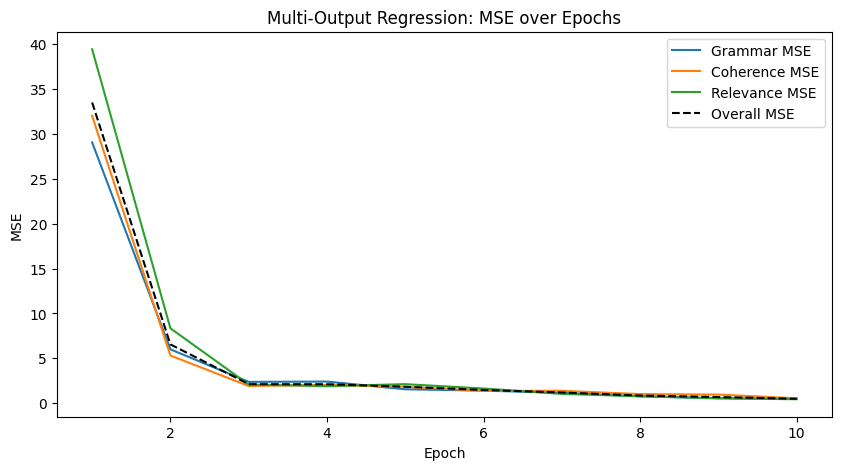

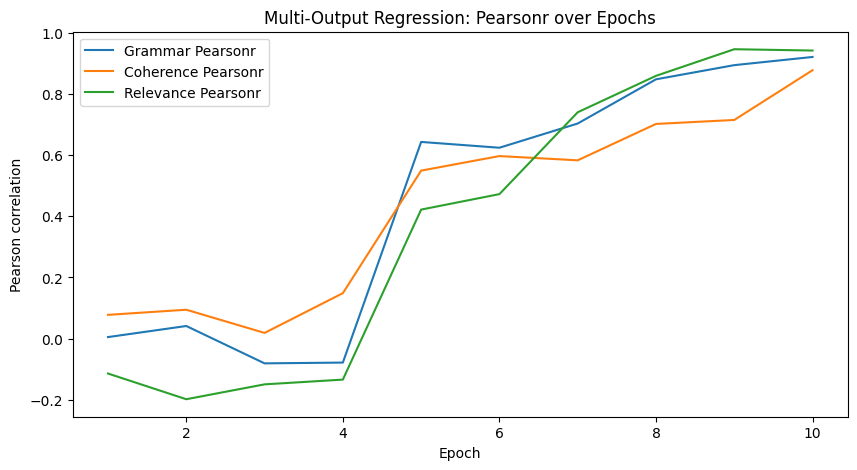

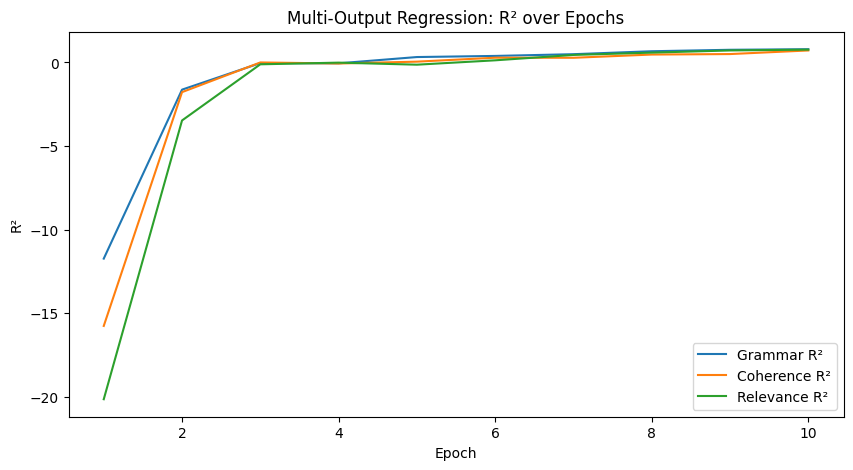

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert trainer log history to DataFrame
logs = pd.DataFrame(trainer.state.log_history)

# Only keep evaluation rows
eval_logs = logs[logs['epoch'].notnull() & logs['eval_loss'].notnull()]

# Metrics to plot
metrics = ["eval_grammar_mse", "eval_coherence_mse", "eval_relevance_mse",
           "eval_grammar_mae", "eval_coherence_mae", "eval_relevance_mae",
           "eval_grammar_pearsonr", "eval_coherence_pearsonr", "eval_relevance_pearsonr",
           "eval_grammar_r2", "eval_coherence_r2", "eval_relevance_r2",
           "eval_mse"]  # overall MSE

# Plot MSE per output + overall
plt.figure(figsize=(10,5))
plt.plot(eval_logs["epoch"], eval_logs["eval_grammar_mse"], label="Grammar MSE")
plt.plot(eval_logs["epoch"], eval_logs["eval_coherence_mse"], label="Coherence MSE")
plt.plot(eval_logs["epoch"], eval_logs["eval_relevance_mse"], label="Relevance MSE")
plt.plot(eval_logs["epoch"], eval_logs["eval_mse"], label="Overall MSE", linestyle='--', color='black')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Multi-Output Regression: MSE over Epochs")
plt.legend()
plt.show()

# Plot Pearson correlation per output
plt.figure(figsize=(10,5))
plt.plot(eval_logs["epoch"], eval_logs["eval_grammar_pearsonr"], label="Grammar Pearsonr")
plt.plot(eval_logs["epoch"], eval_logs["eval_coherence_pearsonr"], label="Coherence Pearsonr")
plt.plot(eval_logs["epoch"], eval_logs["eval_relevance_pearsonr"], label="Relevance Pearsonr")
plt.xlabel("Epoch")
plt.ylabel("Pearson correlation")
plt.title("Multi-Output Regression: Pearsonr over Epochs")
plt.legend()
plt.show()

# Plot R² per output
plt.figure(figsize=(10,5))
plt.plot(eval_logs["epoch"], eval_logs["eval_grammar_r2"], label="Grammar R²")
plt.plot(eval_logs["epoch"], eval_logs["eval_coherence_r2"], label="Coherence R²")
plt.plot(eval_logs["epoch"], eval_logs["eval_relevance_r2"], label="Relevance R²")
plt.xlabel("Epoch")
plt.ylabel("R²")
plt.title("Multi-Output Regression: R² over Epochs")
plt.legend()
plt.show()


**GROUND TRUTH AND TESTING**

In [20]:
# ============================================================
# 17. FULL GROUND TRUTH ESSAY COMPARISON (WITH TEXT)
# ============================================================

import pandas as pd
import numpy as np

print("\n📝 Generating full ground-truth evaluation...")

# 1️⃣ Get predictions (multi-output)
raw_preds = trainer.predict(tokenized_test)
pred_scores = raw_preds.predictions  # shape: [num_samples, 3]

# 2️⃣ Extract true labels
true_scores = np.array(dataset["test"]["labels"])  # shape: [num_samples, 3]

# 3️⃣ Extract row IDs for correct mapping
test_row_ids = dataset["test"]["row_id"]

# 4️⃣ Build numeric-only evaluation table
results_df = pd.DataFrame({
    "row_id": test_row_ids,
    "true_grammar": true_scores[:, 0],
    "true_coherence": true_scores[:, 1],
    "true_relevance": true_scores[:, 2],
    "pred_grammar": pred_scores[:, 0],
    "pred_coherence": pred_scores[:, 1],
    "pred_relevance": pred_scores[:, 2],
})

# Compute final score and errors
results_df["true_final"] = results_df[["true_grammar", "true_coherence", "true_relevance"]].mean(axis=1)
results_df["pred_final"] = results_df[["pred_grammar", "pred_coherence", "pred_relevance"]].mean(axis=1)
results_df["error_final"] = results_df["pred_final"] - results_df["true_final"]
results_df["abs_error_final"] = results_df["error_final"].abs()

# Save numeric results
results_df.to_csv("prediction_results_multioutput.csv", index=False)
print("💾 Saved prediction_results_multioutput.csv (numeric results only)")

# 5️⃣ Merge with original essays using row_id
full_results = results_df.merge(
    df[["row_id", "essay_text"]],
    on="row_id",
    how="left"
)

# Rearrange columns
full_results = full_results[[
    "essay_text",
    "true_final",
    "pred_final",
    "error_final",
    "abs_error_final",
    "true_grammar",
    "pred_grammar",
    "true_coherence",
    "pred_coherence",
    "true_relevance",
    "pred_relevance",
    "row_id"
]]

# Save full results
full_results.to_csv("essay_ground_truth_predictions_multioutput.csv", index=False)
print("💾 Saved essay_ground_truth_predictions_multioutput.csv (includes essays + scores)")

print("\n📘 Example rows with essays:")
print(full_results.head(5))

# 6️⃣ Identify worst predictions
worst_df = full_results.sort_values(by="abs_error_final", ascending=False).head(15)
worst_df.to_csv("worst_predictions_multioutput.csv", index=False)

print("⚠️ Saved worst_predictions_multioutput.csv (top 15 highest errors)")
print("\n🚨 Top 5 Worst Predictions:")
print(worst_df.head(5))



📝 Generating full ground-truth evaluation...


💾 Saved prediction_results_multioutput.csv (numeric results only)
💾 Saved essay_ground_truth_predictions_multioutput.csv (includes essays + scores)

📘 Example rows with essays:
                                          essay_text  true_final  pred_final  \
0  Water pollution affects both human health and ...    6.510000    6.054688   
1  Education equips students with knowledge and c...    5.963333    5.276042   
2  Water pollution affects both human health and ...    7.606667    7.760417   
3  Artificial intelligence is transforming educat...    9.110000    8.752604   
4  Education equips students with knowledge and c...    7.103333    6.337240   

   error_final  abs_error_final  true_grammar  pred_grammar  true_coherence  \
0    -0.455313         0.455313          5.81      5.292969            7.39   
1    -0.687292         0.687292          5.52      5.003906            7.16   
2     0.153750         0.153750          5.69      6.644531            8.01   
3    -0.357396         0.3

In [21]:
# ================= Interactive Essay Scoring (Multi-Output) =================


# Load embedding model for semantic/relevance only
embed_model = SentenceTransformer("all-MiniLM-L6-v2", device=model.bert.device)

# Define topic prompts
topic_prompts = {
    "education": "Discuss the importance of education in modern society.",
    "environment": "Explain how humans can protect and improve the environment.",
    "ai": "Discuss the impact of artificial intelligence on society and daily life.",
    "health": "Explain why health and healthcare are important for society.",
    "other": "Discuss the given topic."
}

# ================= Define Essay Scoring Function =================
def score_essay(text):
    topic = "other"
    prompt_text = topic_prompts[topic]

    # Compute semantic/relevance feature
    essay_emb = embed_model.encode(text, convert_to_tensor=True)
    prompt_emb = embed_model.encode(prompt_text, convert_to_tensor=True)
    semantic_score = (util.cos_sim(essay_emb, prompt_emb).item() + 1)/2  # scaled 0-1

    # Build input_text for model
    input_text = f"Topic: {topic}. Prompt: {prompt_text}\n\nEssay: {text}"

    # Tokenize
    enc = tokenizer(
        input_text,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )
    enc = {k: v.to(model.bert.device) for k, v in enc.items()}

    # Run multi-output BERT model
    with torch.no_grad():
        outputs = model(**enc)
        scores = outputs["logits"].squeeze().cpu().numpy()

    # ------------------------------
    # Sentence-level grammar penalty
    # ------------------------------
    matches = tool.check(text)
    grammar_penalty = len(matches) * 0.1  # reduce 0.1 point per detected error
    grammar_score = max(scores[0] - grammar_penalty, 0)  # ensure >= 0

    return {
        "grammar_score": float(grammar_score),
        "coherence_score": float(scores[1]),
        "relevance_score": float(scores[2]),
        "final_score": float(np.mean([grammar_score, scores[1], scores[2]])),
        "semantic_score": float(semantic_score*10)  # optional
    }

# ================= Interactive Loop =================
print("\n🟢 Interactive Essay Scoring Ready!")
print("Type or paste an essay below.")
print("Type 'quit' to exit.\n")

while True:
    user_input = input("📝 Enter essay: ")

    if user_input.lower().strip() in ["quit", "exit", "q"]:
        print("👋 Exiting essay scoring tool.")
        break

    if len(user_input.strip()) < 20:
        print("⚠️ Essay too short. Please enter at least 20 characters.\n")
        continue

    try:
        scores = score_essay(user_input)
        print(f"\n🎯 Predicted Final Score: {scores['final_score']:.2f}")
        print(f"✏️ Grammar Score: {scores['grammar_score']:.2f}")
        print(f"🔗 Coherence Score: {scores['coherence_score']:.2f}")
        print(f"📌 Relevance Score: {scores['relevance_score']:.2f}")
        print(f"💡 Semantic Score (0-10 scale, optional): {scores['semantic_score']:.2f}\n")
    except Exception as e:
        print("❌ Error scoring essay:", e, "\n")


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



🟢 Interactive Essay Scoring Ready!
Type or paste an essay below.
Type 'quit' to exit.

📝 Enter essay: The internet has become an essential part of daily life, shaping how people communicate, learn, and work. With just a few clicks, anyone can access information that once required hours in a library. It connects friends and families across long distances and allows businesses to reach customers worldwide. Despite its benefits, the internet also presents challenges, such as distractions, misinformation, and privacy concerns. Still, when used responsibly, it remains one of the most powerful tools ever created, offering endless opportunities for growth, creativity, and connection.

🎯 Predicted Final Score: 8.53
✏️ Grammar Score: 8.55
🔗 Coherence Score: 8.73
📌 Relevance Score: 8.29
💡 Semantic Score (0-10 scale, optional): 5.73

📝 Enter essay: quit
👋 Exiting essay scoring tool.


In [22]:
# Using your original dataframe `df`
test_row_ids = dataset["test"]["row_id"]
test_df = df[df["row_id"].isin(test_row_ids)][["row_id", "essay_text", "final_score"]]

# Save as CSV
test_df.to_csv("ground_truth_test_set.csv", index=False)
print("✅ Ground-truth test set saved correctly.")


✅ Ground-truth test set saved correctly.


In [23]:
import pandas as pd

# Load the CSV
ground_truth = pd.read_csv("ground_truth_test_set.csv")

# 🔹 Show full text without truncation
pd.set_option('display.max_colwidth', None)  # Show full essay_text
pd.set_option('display.max_rows', 20)       # Show up to 20 rows at a time

# 🔹 Display first few rows nicely
print("\n📄 First few rows of the ground-truth test set:")
print(ground_truth.head())

# 🔹 Inspect full structure
print("\nℹ️ DataFrame info:")
print(ground_truth.info())

# 🔹 Check numeric statistics
print("\n📊 Summary statistics:")
print(ground_truth.describe())

# 🔹 Optional: Print each essay fully row by row
print("\n📝 Full essay preview (first 5 rows):")
for i, row in ground_truth.head(5).iterrows():
    print(f"Row {row['row_id']} - Final Score: {row['final_score']}")
    print(row['essay_text'])
    print("-"*80)



📄 First few rows of the ground-truth test set:
   row_id  \
0       2   
1       6   
2       7   
3      11   
4      21   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           essay_text  \
0         Reading daily improves vocabulary, comprehension, and analytical thinking. It contributes to overall academic performance. Artificial intelligence is transforming education. Personalized learning systems help students progress at their own pace. Climate change is one of the most urgent global challenges. Immediate action from governments and communities is